In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register
from More_futuristic_LSTM import*

import random


In [7]:
class Dam():

    def __init__(self, observation_data: pd.DataFrame):
        self.data = observation_data
        self.flow_rate = 18000
        self.sell_efficiency = 0.9
        self.buy_efficiency = 0.8
        self.water_capacity = self.flow_rate * 21
        self.conversion_factor = 1000 * 9.81 * 30 * (2 + (7/9)) * (10 ** -10)

    def _get_obs(self):
        self.hour = self.data["hour"].iloc[self.index]
        self.day = self.data["day"].iloc[self.index]
        self.week = self.data["week"].iloc[self.index]
        self.month = self.data["month"].iloc[self.index]
        self.electricity_cost = self.data["prices"].iloc[self.index]

        return {
            "time_hour": self.hour, 
            "time_day": self.day,
            "time_week": self.week,
            "time_month": self.month,
            "water_level": self.water_level,
            "electricity_cost": self.electricity_cost,
            "cash": self.cash,
            "value": self.value
        }
    
    def _get_info(self):
        return {
            "profit": (self.cash - self.starting_cash),
            "unrealized_profit": self.water_level * self.electricity_cost * self.sell_efficiency * self.conversion_factor,
            "total_value": (self.cash - self.starting_cash) + (self.water_level * self.electricity_cost * self.sell_efficiency * self.conversion_factor)
            }
    
    def step(self, action, terminated=False):
        info = self._get_info()
        previous_total_value = info["total_value"]
        # first check if simulation terminates, otherwise move index and perform action
        if (self.index+1) == self.data.shape[0] or (self.water_level == 0 and self.cash == 0):
            terminated = True
        else:
            # otherwise continue
            self.index += 1

            # we can only sell if there is water in the dam
            if action == 'sell' and self.water_level != 0:
                if self.water_level > self.flow_rate:
                    self.cash += self.electricity_cost * self.sell_efficiency * self.flow_rate * self.conversion_factor
                    self.water_level -= self.flow_rate
                else:
                    self.cash += self.electricity_cost * self.sell_efficiency * self.water_level * self.conversion_factor
                    self.water_level = 0
                    
            # we can only buy if we have cash and if dam is not full
            elif action == 'buy' and (self.water_level < self.water_capacity):
                if (self.water_capacity - self.water_level) > self.flow_rate:
                    self.cash -= self.electricity_cost * self.flow_rate * self.conversion_factor / self.buy_efficiency
                    self.water_level += self.flow_rate
                else:
                    self.cash -= self.electricity_cost * (self.water_capacity - self.water_level) * self.conversion_factor / self.buy_efficiency
                    self.water_level = self.water_capacity
                    
        observation = self._get_obs()
        info = self._get_info()
        self.value = info["total_value"]
        if self.value > previous_total_value:
            reward = 1
        else:
            reward = -1
        return observation, reward, terminated, False, info

    def reset(self):
        self.index = 0
        self.hour = self.data["hour"].iloc[self.index]
        self.day = self.data["day"].iloc[self.index]
        self.week = self.data["week"].iloc[self.index]
        self.month = self.data["month"].iloc[self.index]

        self.water_level = 50000  # half of maximum water level
        self.starting_cash = 0  # (arbitrary) amount of cash
        self.cash = self.starting_cash
        self.electricity_cost = self.data["prices"].iloc[self.index]
        self.value = self.starting_cash + (self.electricity_cost * self.water_level)
        
        observation = self._get_obs()
        info = self._get_info()
        return observation, info


In [8]:
train_data = pd.read_csv('data/train_processed.csv')
val_data = pd.read_csv('data/val_processed.csv')
dam=Dam(val_data)

In [9]:
#LSTM Hyperparameters
num_time_steps = 27
num_predict_steps=3
units=150
epochs=12
batch_size=32
num_features=1

'''#TRAIN MODEL
model, y_pred = LSTM_Train(train_data, num_time_steps=num_time_steps,num_predict_steps=num_predict_steps, units=units, epochs=epochs, batch_size=batch_size)

with open(f'./LSTMmodel.pickle', 'wb') as f:
    pickle.dump(model, f)'''


"#TRAIN MODEL\nmodel, y_pred = LSTM_Train(train_data, num_time_steps=num_time_steps,num_predict_steps=num_predict_steps, units=units, epochs=epochs, batch_size=batch_size)\n\nwith open(f'./LSTMmodel.pickle', 'wb') as f:\n    pickle.dump(model, f)"

In [10]:
with open(f'./LSTMmodel-66.pickle','rb') as f:
    model = pickle.load(f)
    
X, Y = prepare_data(val_data, num_time_steps=num_time_steps, num_predict_steps=num_predict_steps)
Y_pred = model.predict(X)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-01-31 01:37:58         1780
metadata.json                                  2023-01-31 01:37:58           64
variables.h5                                   2023-01-31 01:37:58      1117584
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
547/547 [==============================] - 4s 6ms/step


In [11]:
action_list = assign_action_points(Y_pred, X)


c:\Users\anton\py_versions\py3104\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [12]:
#action_list.pop()
len(action_list)


17520

In [13]:
def evaluate():
    init_obs = dam.reset()
    rewards = 0
    action_sequence, cash, water_level, all_rewards = [], [], [], []
    for action in action_list:
        if action==1:
            action='buy'
        elif action==-1:
            action='sell'
        else:
            action='hold'
        action_sequence.append(action)
        next_state, reward, terminated, truncated, info = dam.step(action)
        rewards += reward
        water_level.append(next_state["water_level"])
        all_rewards.append(rewards)
        cash.append(info["profit"])

    print('The evaluation is done!')
    return action_sequence, cash, all_rewards, water_level

In [14]:
actions, cash, rewards, water_level = evaluate()

The evaluation is done!


In [15]:

#val_data = pd.read_csv('data/val_processed.csv')
df = pd.DataFrame({"prices": val_data["prices"], 'actions': actions, "cash": cash, "water_level": water_level, "rewards": rewards})
df.to_csv('data/eval_lstm.csv')


<AxesSubplot:>

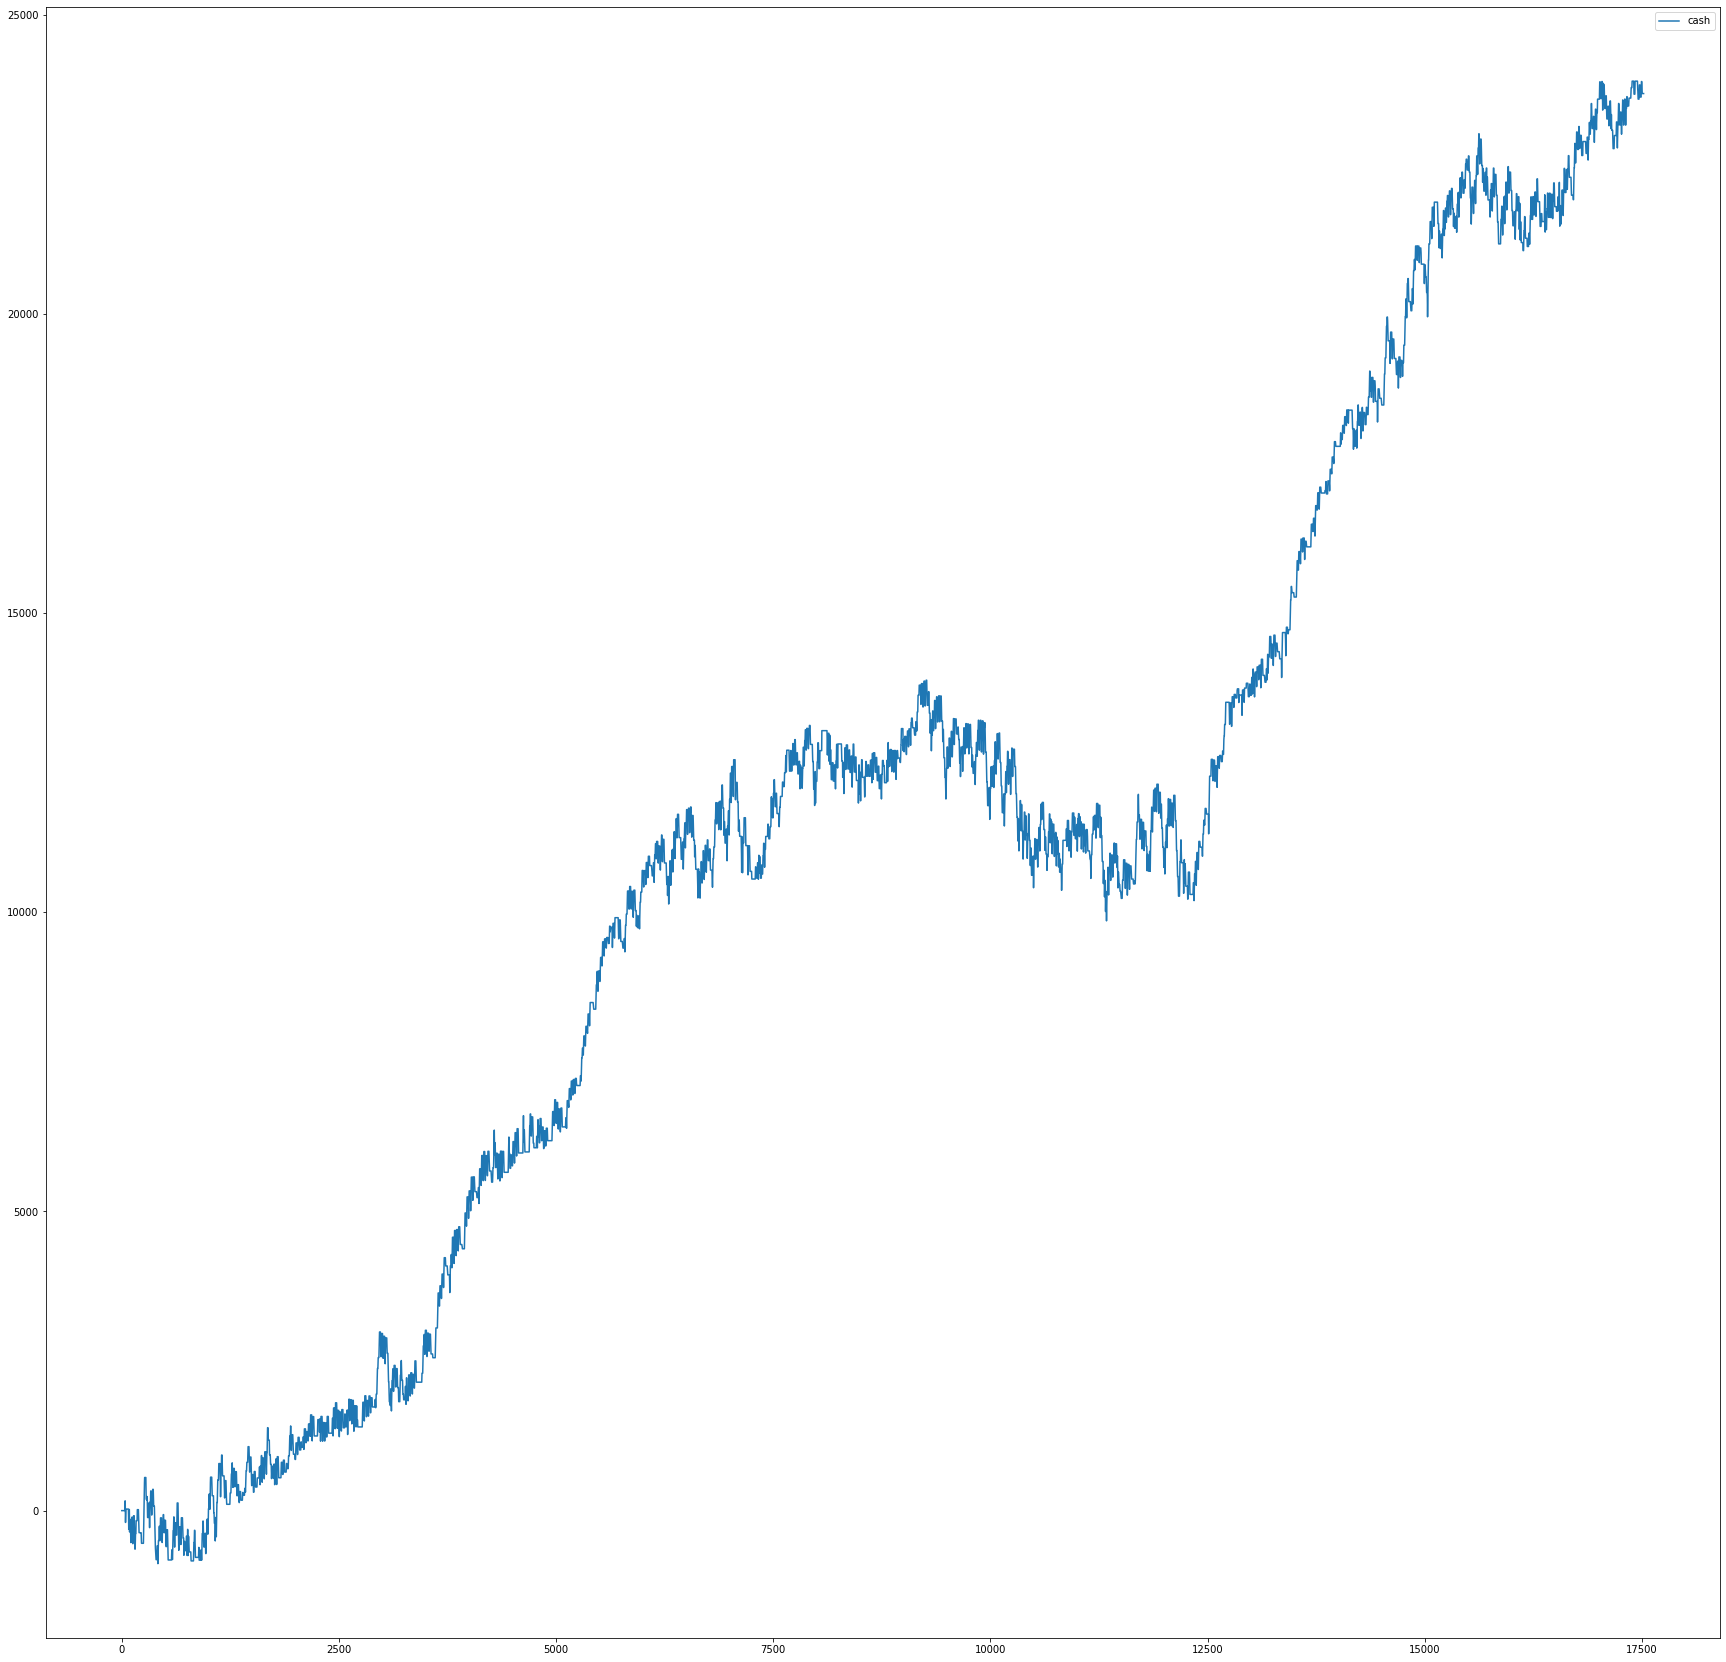

In [16]:
df.plot(x=None, y="cash", kind="line", figsize=(30, 30))